In [41]:
import praw
import json

In [42]:
## Reddit API credentials.
# User
user_name = 'Weekly-Fishing5829'

# Registered application (script-type)
app_id = 'OiOgsf4CXvEEENcav0z2VA'
app_secret = 'tUyFfRwJjHrX2WYwLtbQ1tGIPc93xw'

In [43]:
# establish an API connection
reddit = praw.Reddit(user_agent=f"Exploration script by /u/{user_name}",
                     client_id=app_id,
                     client_secret=app_secret)

In [44]:
# returns True for read-only connection, if everything is configured correctly
reddit.read_only

True

In [72]:
# choose a subreddit of interest

query_subreddit = 'CryptoCurrency'

In [73]:
# decide how many top-"hot" posts to query
nposts = 50

In [74]:
# collect ids of the top posts within the chosen subreddit
post_ids = []
subreddit = reddit.subreddit(query_subreddit)
for p in subreddit.hot(limit = nposts):
    post_ids.append(p.id)
# check how many posts (submissions) were collected
len(post_ids)

50

In [75]:
# example post details
post_details = reddit.submission(id = post_ids[1])
print(post_details.title)
print(post_details.selftext)

Daily General Discussion - July 30, 2022 (GMT+0)
**Welcome to the Daily General Discussion thread. Please read the disclaimer and rules before participating.**
 
***
&nbsp;
    
###Disclaimer:

Consider all information posted here with several liberal heaps of salt, and always cross check any information you may read on this thread with known sources. Any trade information posted in this open thread may be highly misleading, and could be an attempt to manipulate new readers by known "pump and dump (PnD) groups" for their own profit. BEWARE of such practices and exercise utmost caution before acting on any trade tip mentioned here. 


**Please be careful about what information you share and the actions you take.** Do not share the amounts of your portfolios (why not just share percentage?). Do not share your private keys or wallet seed. Use strong, non-SMS 2FA if possible. Beware of scammers and be smart. Do not invest more than you can afford to lose, and do not fall for pyramid scheme

In [76]:
# decide how many top comments to query per post;
# NOTE: larger number of comments may dilute the content (irrelevant text)
ncomments = 10

In [77]:
# function to collect post data
def collect_post_data(post_id, ncomments, reddit):
    psubm = reddit.submission(id = post_id)
    pdata = {'id': post_id, 'title': psubm.title, 'text': psubm.selftext}
    
    # collect first- and second-level comments
    pcomm = []
    psubcomm = []
    psubm.comments.replace_more(limit = ncomments)
    for top_comment in psubm.comments:
        pcomm.append(top_comment.body)
        for lev2_comment in top_comment.replies:
            psubcomm.append(lev2_comment.body)
    
    # assemble the data together
    pdata['comments_lev1'] = pcomm
    pdata['comments_lev2'] = psubcomm
    
    return pdata

In [78]:
# collect information for each post
posts_all = [collect_post_data(pid, ncomments, reddit) for pid in post_ids]

In [79]:
# save collected data to json file
file_out = f"raw_post_comment_data.json"
with open(file_out, mode='w') as f:
    f.write(json.dumps(posts_all, indent=2))

In [80]:
# Reddit data analysis task starter.
import html
import json
import string
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import *
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt

In [81]:
# First collect the data in json-file (follow reddit_collect_data.ipynb); specify file name here
fjson = 'raw_post_comment_data.json'

In [82]:
# read json file with collected posts and comments
# https://docs.python.org/3/tutorial/inputoutput.html#reading-and-writing-files
with open(fjson) as file:
    data = json.load(file)
len(data)

50

In [83]:
# data record example
data[0]

{'id': 'vpazdp',
 'title': 'Monthly Optimists Discussion - July 2022',
 'text': "Welcome to the Monthly Optimists Discussion thread. As the title implies, the purpose of this thread is to promote discussion which is guardedly optimistic about cryptocurrency topics. This thread is intended to be a counterweight to the Skeptics Discussion thread and will be pinned when the markets are bearish.\n\nPlease read the rules and guidelines before participating.\n\n---\n&nbsp;\n\n###Rules:\n\nThis discussion thread has much higher standards compared to the Daily Discussion thread. Please behave in accordance with the following rules.\n\n 1. All [r/CC rules](https://www.reddit.com/r/CryptoCurrency/about/rules) apply.\n\n 2. For top-level comments, a minimum of 250 characters will be imposed as well as a minimum of 1000 comment karma and 6 months account age.\n\n 3. Discussions must be on topic, ie positive but not to the point of being absurd or utopian. Statements should be substantiated with so

In [84]:
# create pandas dataframe from post titles
# https://stackoverflow.com/a/43175477
df_posts = pd.DataFrame([p['title'] for p in data], columns=['title'])
df_posts

,title
0,Monthly Optimists Discussion - July 2022
1,"Daily General Discussion - July 30, 2022 (GMT+0)"
2,Vitalik and Ethereum Developers Have Dumped a ...
3,How I Coped With Losing My Entire Portfolio to...
4,You should consider all money invested in cryp...
5,Over 50% of Staked Ethereum Held by 4 “Central...
6,The Power of Inversion - Why the Majority Will...
7,Honduras launches 'Bitcoin Valley' in the tour...
8,Binance's CZ: High Inflation And Recession Fea...
9,Ripple’s XRP-Powered Cross-Border Payment Prod...


In [86]:
# add columns from other data fields: combine comment and sub-comment text
df_posts['post_id'] = [p['id'] for p in data]
df_posts['text'] = [p['text'] for p in data]
df_posts['comments_lev1'] = [' '.join(p['comments_lev1']) for p in data]
df_posts['comments_lev2'] = [' '.join(p['comments_lev2']) for p in data]
df_posts


,title,post_id,text,comments_lev1,comments_lev2
0,Monthly Optimists Discussion - July 2022,vpazdp,Welcome to the Monthly Optimists Discussion th...,There's definitely a long road ahead before we...,"Good to know, I just went all in, 10X leverage..."
1,"Daily General Discussion - July 30, 2022 (GMT+0)",wbjii0,**Welcome to the Daily General Discussion thre...,One day Bitcoin is gonna allow me to give up w...,Same 😔 Never gonna happen for me. It's sad but...
2,Vitalik and Ethereum Developers Have Dumped a ...,wbxw4q,"Listen, I know everyone on this sub loves ethe...",Ethereum [pros](/r/CryptoCurrency/comments/wbx...,* Relevant Cointest topics: [Cardano](https://...
3,How I Coped With Losing My Entire Portfolio to...,wbqz78,A lot of people lost everything. My whole port...,We think we have time until suddenly we dont H...,I was sitting waiting for a train that would c...
4,You should consider all money invested in cryp...,wbvs3v,Before you invest any money in crypto say good...,If you're putting money into something and tre...,"Sir, this is a casino This. Don’t invest in so..."
5,Over 50% of Staked Ethereum Held by 4 “Central...,wbr9rr,,Ethereum [pros](/r/CryptoCurrency/comments/wbr...,* Relevant Cointest topics: [Cardano](https://...
6,The Power of Inversion - Why the Majority Will...,wc1drr,# For the Very Same Reasons They Missed the Ex...,Power of Inversion sounds like a fancy way of ...,>Power of Inversion\n\nIt's a concept made fam...
7,Honduras launches 'Bitcoin Valley' in the tour...,wbt2ah,,Bitcoin [pros](/r/CryptoCurrency/comments/wbt2...,* Relevant Cointest topics: [Bitcoin Cash](htt...
8,Binance's CZ: High Inflation And Recession Fea...,wbstld,,CZ obviously totally impartial in his observat...,Could you not apply this take to literally eve...
9,Ripple’s XRP-Powered Cross-Border Payment Prod...,wbw4a3,,Fuck the SEC It’s crazy how much growth outsid...,All my homies hate the SEC. They are too bad t...


In [128]:
# text cleaning function: see prior class modules
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
stop_words.add('ie')
stop_words.add('eth')
stop_words.add('ww3')
stop_words.add('gon')
stop_words.add('na')
print(stop_words)


# strictly speaking, this is a closure: uses a wider-scope variable stop_words
# (disregard this note if you are a Python beginner)
def text_cleanup(s):
    s_unesc = html.unescape(re.sub(r"http\S+", "", re.sub('\n+', ' ', s)))
    s_noemoji = s_unesc.encode('ascii', 'ignore').decode('ascii')
    # normalize to lowercase and tokenize
    wt = word_tokenize(s_noemoji.lower())
    
    # filter word-tokens
    wt_filt = [w for w in wt if (w not in stop_words) and (w not in string.punctuation) and (w.isalnum())]
    
    # return clean string
    return ' '.join(wt_filt)

{"hasn't", 'won', 'doing', 'ours', 'wasn', 'd', 'out', 'myself', 'those', 'only', 'itself', 'here', 'your', "isn't", "you'll", 'of', 'with', 'between', "you've", 'yours', 'for', 'mustn', 'from', 'while', 'needn', 's', 'until', 've', 'y', 'hadn', 'we', 'where', 'mightn', 'has', 'when', 'she', 'why', 'aren', 'having', 'which', 'there', 'against', 'o', 'what', 'wouldn', "she's", 'off', 'a', 'very', 'during', 'whom', "haven't", 'any', 'the', 'herself', "you're", "you'd", 'them', "doesn't", 'are', 'about', 'he', 're', 'into', 'then', "couldn't", 'haven', 'both', 'over', 'should', 'is', 'again', 'further', 'because', 'shan', 'by', 'down', 'll', 'through', 'na', 'before', 'than', 'their', 'same', 'hers', 'as', 'his', 'and', 'ma', "shan't", 'were', 'that', 'these', 'theirs', 'isn', 'under', 't', 'didn', 'an', "didn't", "hadn't", 'been', 'does', 'so', 'shouldn', 'weren', 'gon', 'nor', 'do', 'in', 'm', 'each', 'it', 'too', 'most', "shouldn't", 'above', 'yourself', 'ain', 'her', 'not', 'no', 'has

In [129]:
# add clean text column with combined comments of both levels
# NOTE: apply in pandas applies a function to each element of the selected column
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
df_posts['text_clean'] = (df_posts['text'] + df_posts['comments_lev1'] + df_posts['comments_lev2']).apply(text_cleanup)
df_posts

,title,post_id,text,comments_lev1,comments_lev2,text_clean
0,Monthly Optimists Discussion - July 2022,vpazdp,Welcome to the Monthly Optimists Discussion th...,There's definitely a long road ahead before we...,"Good to know, I just went all in, 10X leverage...",welcome monthly optimists discussion thread ti...
1,"Daily General Discussion - July 30, 2022 (GMT+0)",wbjii0,**Welcome to the Daily General Discussion thre...,One day Bitcoin is gonna allow me to give up w...,Same 😔 Never gonna happen for me. It's sad but...,welcome daily general discussion thread please...
2,Vitalik and Ethereum Developers Have Dumped a ...,wbxw4q,"Listen, I know everyone on this sub loves ethe...",Ethereum [pros](/r/CryptoCurrency/comments/wbx...,* Relevant Cointest topics: [Cardano](https://...,listen know everyone sub loves ethereum one fi...
3,How I Coped With Losing My Entire Portfolio to...,wbqz78,A lot of people lost everything. My whole port...,We think we have time until suddenly we dont H...,I was sitting waiting for a train that would c...,lot people lost everything whole portfolio cel...
4,You should consider all money invested in cryp...,wbvs3v,Before you invest any money in crypto say good...,If you're putting money into something and tre...,"Sir, this is a casino This. Don’t invest in so...",invest money crypto say goodbye least make pro...
5,Over 50% of Staked Ethereum Held by 4 “Central...,wbr9rr,,Ethereum [pros](/r/CryptoCurrency/comments/wbr...,* Relevant Cointest topics: [Cardano](https://...,ethereum pros cons related info collapsed comm...
6,The Power of Inversion - Why the Majority Will...,wc1drr,# For the Very Same Reasons They Missed the Ex...,Power of Inversion sounds like a fancy way of ...,>Power of Inversion\n\nIt's a concept made fam...,reasons missed exits bear market tldr nobody k...
7,Honduras launches 'Bitcoin Valley' in the tour...,wbt2ah,,Bitcoin [pros](/r/CryptoCurrency/comments/wbt2...,* Relevant Cointest topics: [Bitcoin Cash](htt...,bitcoin pros cons related info collapsed comme...
8,Binance's CZ: High Inflation And Recession Fea...,wbstld,,CZ obviously totally impartial in his observat...,Could you not apply this take to literally eve...,cz obviously totally impartial observation thi...
9,Ripple’s XRP-Powered Cross-Border Payment Prod...,wbw4a3,,Fuck the SEC It’s crazy how much growth outsid...,All my homies hate the SEC. They are too bad t...,fuck sec crazy much growth outside us still ha...


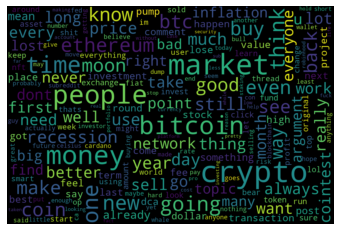

In [130]:
# most common keywords
# https://amueller.github.io/word_cloud/auto_examples/single_word.html#sphx-glr-auto-examples-single-word-py
# https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud
text_combined = ' '.join(df_posts['text_clean'])
wc = WordCloud(width=1200, height=800, max_font_size=110, collocations=False).generate(text_combined)
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

In [131]:
# extract keyword counts
# https://stackoverflow.com/questions/60234036/python-word-count-from-wordcloud
kwords = WordCloud().process_text(text_combined)
kwords

{'welcome': 12,
 'monthly': 9,
 'title': 10,
 'implies': 2,
 'guardedly': 1,
 'optimistic': 9,
 'cryptocurrency': 40,
 'intended': 6,
 'counterweight': 1,
 'pinned': 1,
 'bearish': 7,
 'please': 21,
 'read': 30,
 'guidelines': 2,
 'participating': 3,
 'much': 140,
 'higher': 28,
 'compared': 20,
 'daily': 32,
 'behave': 6,
 'accordance': 1,
 'following': 13,
 'apply': 9,
 'minimum': 6,
 'imposed': 1,
 'well': 134,
 'comment': 6,
 'karma': 7,
 'account': 40,
 'age': 8,
 'must': 34,
 'positive': 21,
 'point': 111,
 'absurd': 5,
 'utopian': 1,
 'substantiated': 2,
 'sound': 39,
 'reason': 52,
 'evidence': 7,
 'example': 25,
 'announcing': 1,
 'obscure': 1,
 'online': 7,
 'store': 7,
 'adopting': 2,
 'coin': 141,
 'x': 7,
 'speculate': 4,
 'amazon': 3,
 'adopt': 4,
 'next': 71,
 'without': 47,
 'market': 338,
 'financial': 17,
 'advice': 15,
 'tech': 28,
 'support': 30,
 'likely': 45,
 'removed': 12,
 'better': 113,
 'suited': 1,
 'promoting': 1,
 'saying': 35,
 'buy': 185,
 'going': 226,


In [132]:
# transform that dictionary into a pandas DataFrame
df_kwords = pd.DataFrame(list(kwords.items()), columns=['keyword', 'count']).set_index('keyword')
df_kwords

,count
keyword,
welcome,12
monthly,9
title,10
implies,2
guardedly,1
...,...
chairman jerome,2
jerome powell,2
echo chamber,2


<AxesSubplot:xlabel='keyword'>

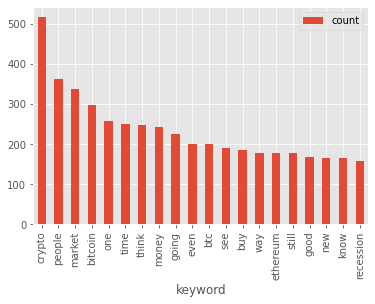

In [133]:
# plot a bar chart with the top keywords
%matplotlib inline
df_kwords.sort_values(by='count', ascending=False).head(20).plot.bar()

In [134]:
# NLTK collocations search (words occuring together): bigrams
# https://www.nltk.org/howto/collocations.html
# http://www.nltk.org/api/nltk.html#nltk.util.bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()
bigram_finder = BigramCollocationFinder.from_documents([d.split() for d in df_posts['text_clean']])

In [135]:
# filter out bigrams occurring less than three times in the combined text
bigram_finder.apply_freq_filter(3)

In [136]:
# list of bigrams with their frequencies
bigram_freq = list(bigram_finder.ngram_fd.items())
bigram_freq

[(('optimists', 'discussion'), 3),
 (('discussion', 'thread'), 28),
 (('skeptics', 'discussion'), 24),
 (('much', 'higher'), 3),
 (('6', 'months'), 10),
 (('coin', 'x'), 4),
 (('financial', 'advice'), 4),
 (('cointest', 'archive'), 43),
 (('archive', 'find'), 43),
 (('discussion', 'threads'), 5),
 (('new', 'ath'), 7),
 (('like', '5k'), 3),
 (('bad', 'macro'), 3),
 (('lot', 'people'), 20),
 (('every', 'day'), 6),
 (('like', 'bitcoin'), 6),
 (('bitcoin', 'ethereum'), 4),
 (('ethereum', 'need'), 3),
 (('297', 'validators'), 3),
 (('bad', 'decentralization'), 4),
 (('would', 'need'), 4),
 (('smart', 'contract'), 17),
 (('contract', 'platform'), 4),
 (('might', 'well'), 7),
 (('much', 'lower'), 4),
 (('would', 'require'), 3),
 (('number', 'tokens'), 3),
 (('validator', 'set'), 3),
 (('period', 'time'), 3),
 (('2', 'years'), 6),
 (('24', 'hours'), 5),
 (('market', 'cap'), 20),
 (('amount', 'money'), 7),
 (('1', 'trillion'), 3),
 (('hedge', 'funds'), 10),
 (('risk', 'management'), 5),
 (('peo

In [137]:
<div class="mark">
# collect into a pandas dataframe
df_freq = pd.DataFrame([(' '.join(k), v) for k,v in bigram_freq], columns=['keyphrase', 'count'])
df_freq.sort_values(by='count', ascending=False, inplace=True)
df_freq.set_index('keyphrase', inplace = True)
df_freq</div><i class="fa fa-lightbulb-o "></i>

,count
keyphrase,
would like,49
long term,47
bear market,46
pros cons,43
cointest archive,43
...,...
benefit using,3
throw money,3
el salvador,3


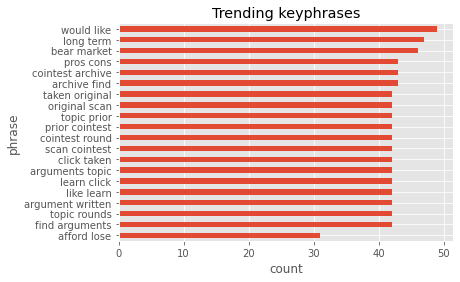

In [138]:
plt.style.use('ggplot')

# render a horizontal bar graph
df_freq.head(20).sort_values(by='count').plot(kind = 'barh')
plt.title('Trending keyphrases')
plt.ylabel('phrase')
plt.xlabel('count')
plt.legend().set_visible(False)
plt.show()